In [1]:
from functions import *
from architectures import *

%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## -----------------------------------------------------------------------------------------------------------------------------

In [2]:
data_lagged_features = pd.read_csv('notoptshit.csv')
data_lagged_features['Date'] = pd.to_datetime(data_lagged_features['Date'])

In [3]:
for c in tqdm(data_lagged_features.drop(['Date', 'Demand', 'Store_id', 'SKU_id'], axis=1).columns):
    a = data_lagged_features[[c, 'Store_id', 'SKU_id', 'Date']].groupby(['Store_id', 'SKU_id']).apply(lambda x : x.set_index('Date').rolling('5D', min_periods=1).mean())[[c]].reset_index()
    merged = data_lagged_features.merge(a, on=['Store_id', 'SKU_id', 'Date'])
    data_lagged_features.loc[data_lagged_features[c].isna(), c] = merged[data_lagged_features[c].isna()][c+'_y']

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:20<00:00,  3.55it/s]


In [4]:
from tqdm.contrib.itertools import product

for c, store, sku in product(data_lagged_features.drop(['Date', 'Demand'], axis=1).columns,
                      data_lagged_features['Store_id'].unique(), data_lagged_features['SKU_id'].unique()):
    cond = (data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)
    data_lagged_features.loc[cond, c] = data_lagged_features[cond][c].fillna(data_lagged_features[cond][c].mean())

  0%|          | 0/16280 [00:00<?, ?it/s]

In [5]:
for c in data_lagged_features.drop(['Date', 'Demand'], axis=1).columns:
    for sku in data_lagged_features['SKU_id'].unique():
        cond = (data_lagged_features['SKU_id'] == sku)
        data_lagged_features.loc[cond, c] = data_lagged_features[cond][c].fillna(data_lagged_features[cond][c].mean())

In [6]:
df_train, df_test, target_mean, target_stdev, target, features = preprocess(data_lagged_features, scl=0)

In [7]:
set_random_seed(7)

In [8]:
df_train = df_train.reset_index()
df_test = df_test.reset_index()

df_train["time_idx"] = df_train['Date'].dt.dayofyear + (df_train['Date'].dt.year - 2015) * 365
df_test["time_idx"] = df_test['Date'].dt.dayofyear + (df_test['Date'].dt.year - 2015) * 365
min_time_idx = df_train["time_idx"].min()
df_train["time_idx"] -= min_time_idx
df_test["time_idx"] -= min_time_idx

In [9]:
df_train['Store_id'] = df_train['Store_id'].astype(str)
df_train['SKU_id'] = df_train['SKU_id'].astype(str)
df_train['Promo'] = df_train['Promo'].astype(str)
df_train['weekday'] = df_train['weekday'].astype(str)
df_train['monthday'] = df_train['monthday'].astype(str)

df_test['Store_id'] = df_test['Store_id'].astype(str)
df_test['SKU_id'] = df_test['SKU_id'].astype(str)
df_test['Promo'] = df_test['Promo'].astype(str)
df_test['weekday'] = df_test['weekday'].astype(str)
df_test['monthday'] = df_test['monthday'].astype(str)

In [10]:
#new_stores = df_test[~df_test['Store_id'].isin(df_train['Store_id'])]['Store_id'].unique()
#df_test.loc[df_test['Store_id'].isin(new_stores), "Store_id"] = "99"
#df_test = df_test.drop(df_test[df_test['Store_id'].isin(new_stores)].index)

In [11]:
df_test['Demand'] = 0

In [103]:
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)
#max_prediction_length = 28
#max_encoder_length = 60
#
#training = TimeSeriesDataSet(
#    df_train,
#    time_idx="time_idx",
#    target="Demand",
#    group_ids=["Store_id", "SKU_id"],
#    #min_encoder_length=0,  # allow predictions without history
#    max_encoder_length=max_encoder_length,
#    #min_prediction_length=1,
#    max_prediction_length=max_prediction_length,
#    static_categoricals=["Store_id", "SKU_id"],
#    static_reals=[],
#    time_varying_known_categoricals=["Promo", "weekday", "monthday"],
#    variable_groups={},
#    time_varying_known_reals=[
#        "time_idx",
#        "Regular_Price",
#        "Actual_Price",
#        "Promo_percent"
#    ] + df_train.columns[df_train.columns.str.contains('lag')].values.tolist(),
#    time_varying_unknown_categoricals=[],
#    time_varying_unknown_reals=["Demand"],
#    target_normalizer=GroupNormalizer(
#        groups=["Store_id", "SKU_id"]
#    ),
#    categorical_encoders={'Store_id': NaNLabelEncoder(add_nan=True)},
#    #add_relative_time_idx=True,
#    add_target_scales=True,
#    add_encoder_length=True,
#    allow_missing_timesteps=True
#)
#
#batch_size = 64
#train_dataloader = training.to_dataloader(
#    train=True, batch_size=batch_size, num_workers=0
#)

max_encoder_length = 60
max_prediction_length = 28

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",
    target="Demand",
    categorical_encoders={"Store_id": NaNLabelEncoder().fit(df_train.Store_id)},
    group_ids=["Store_id", "SKU_id"],
    time_varying_unknown_reals=["Demand"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

In [108]:
import pytorch_lightning as pl
from pytorch_forecasting.metrics import QuantileLoss, SMAPE
from pytorch_forecasting.models import TemporalFusionTransformer, NBeats


trainer = pl.Trainer(
    max_epochs=5,
    gpus=1,
    gradient_clip_val=0.1,
)

net = NBeats.from_dataset(training, learning_rate=4e-3, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1, loss=SMAPE())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [109]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.900     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

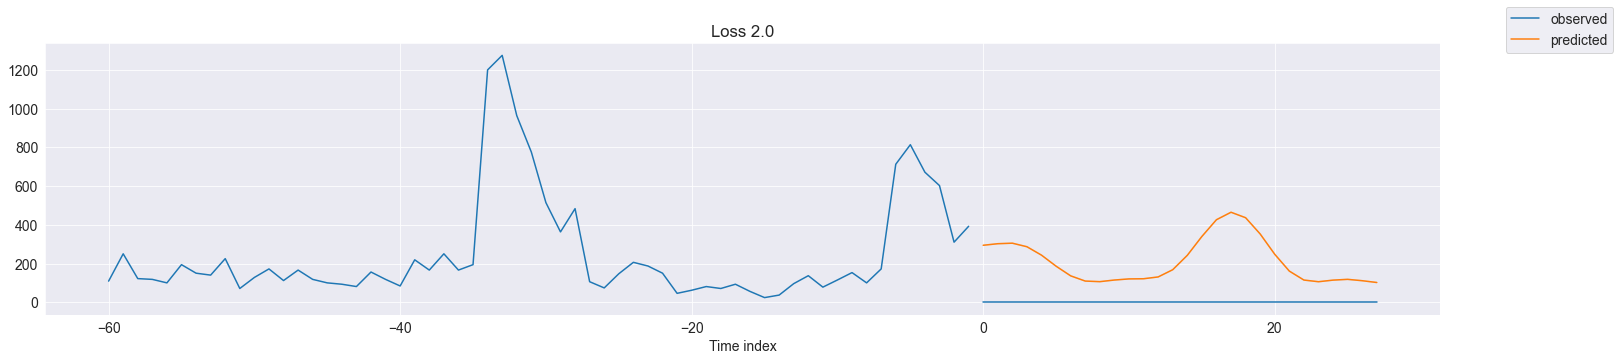

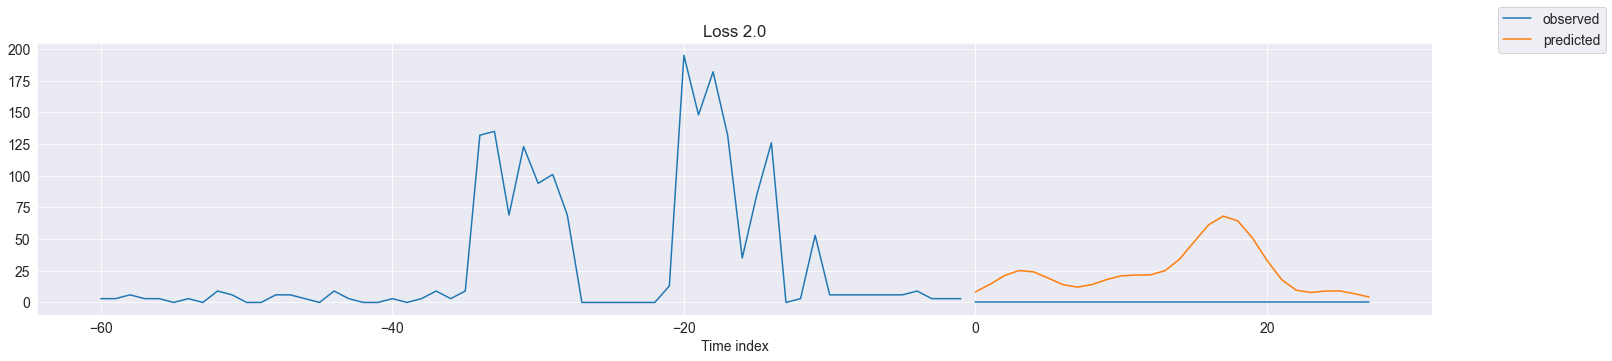

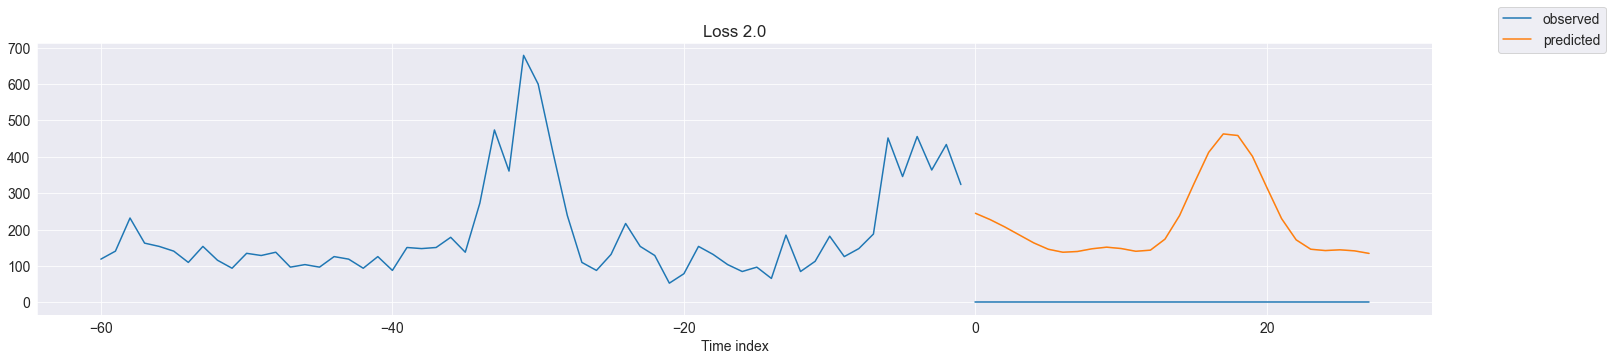

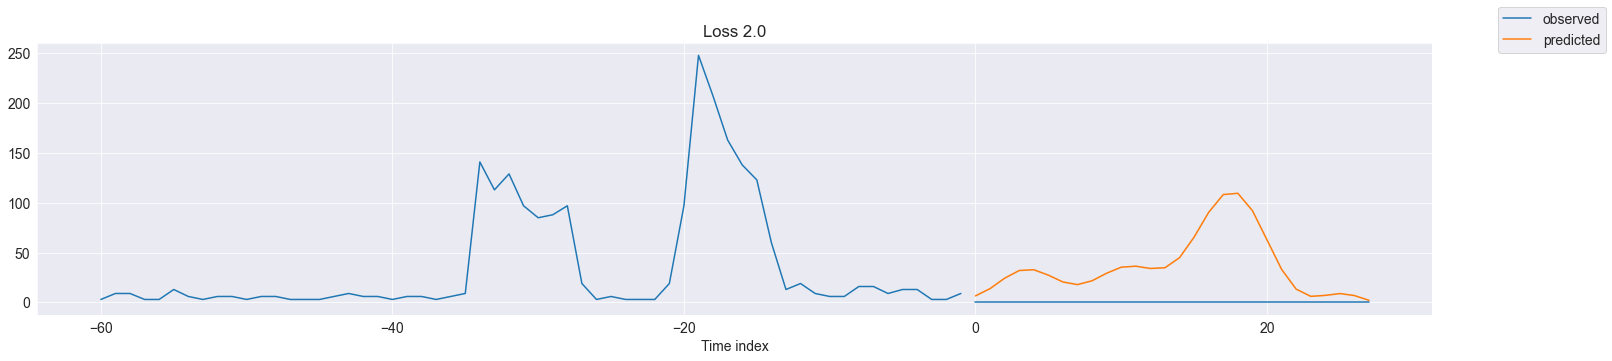

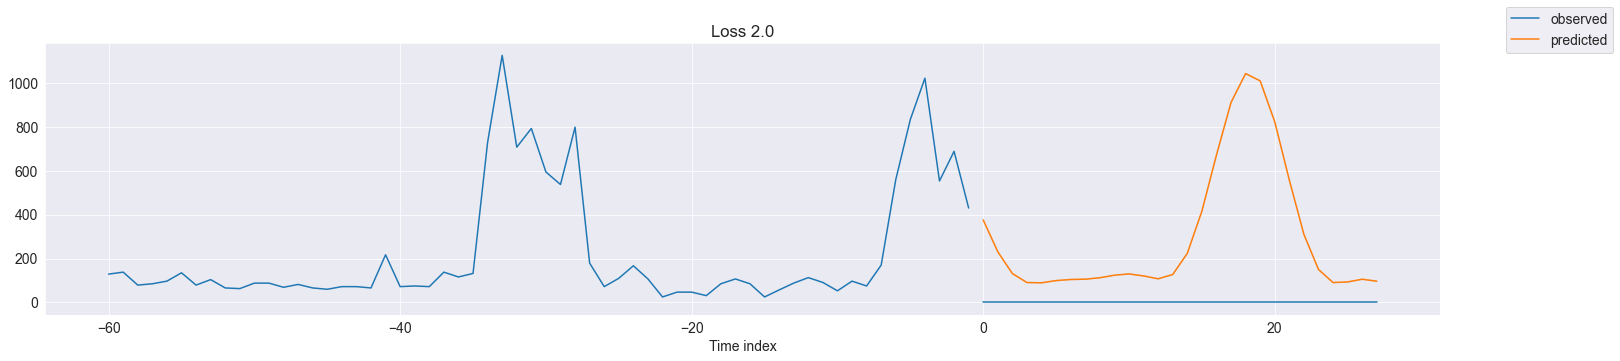

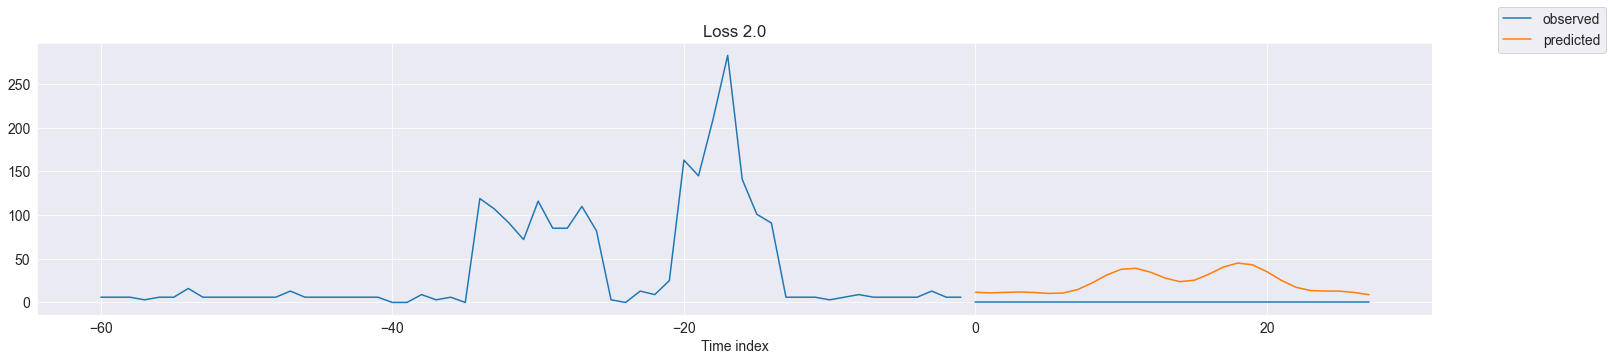

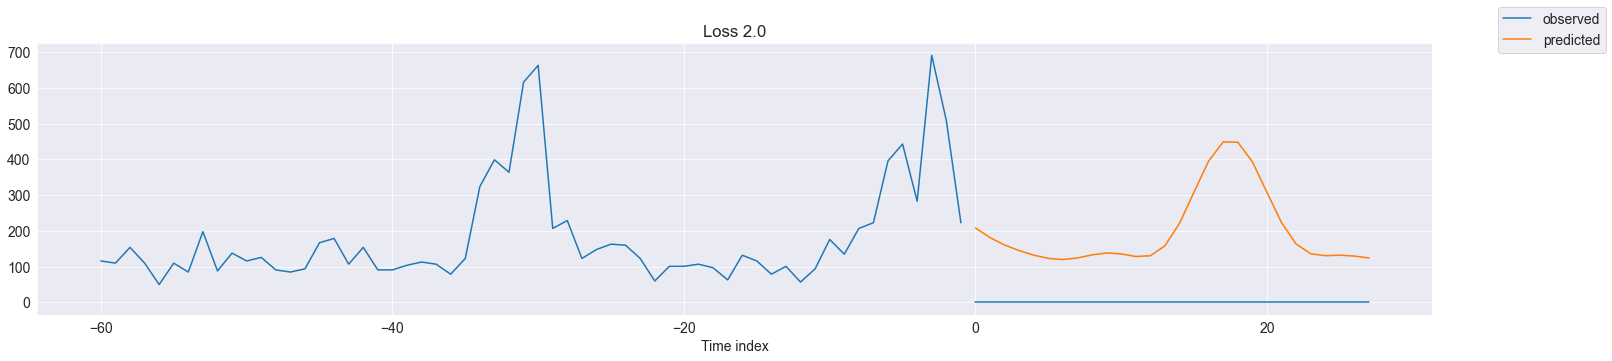

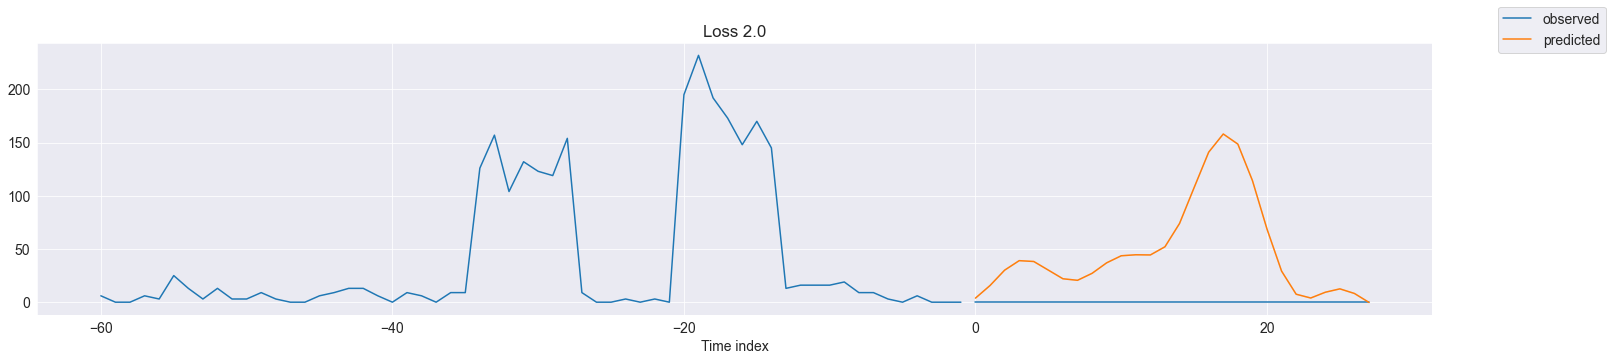

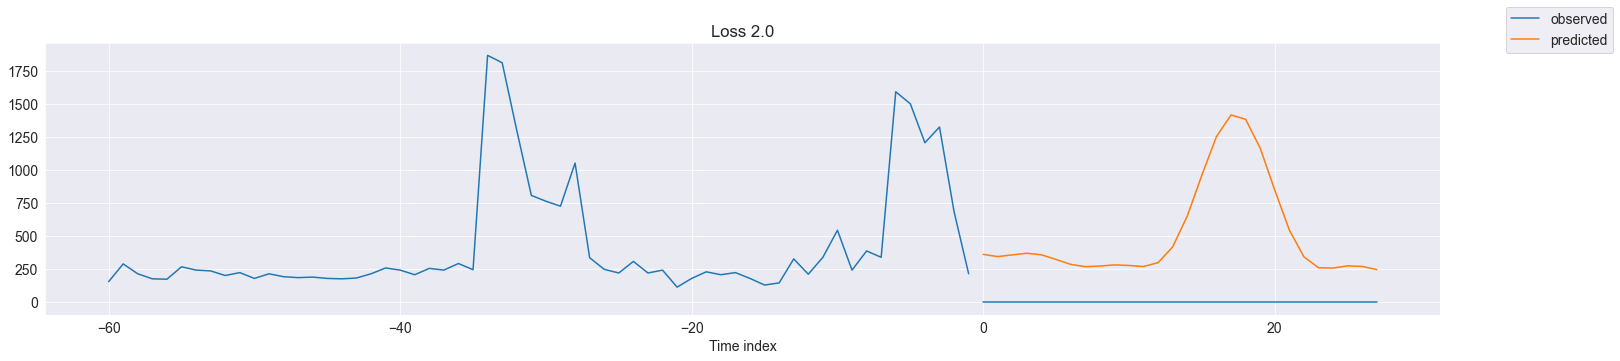

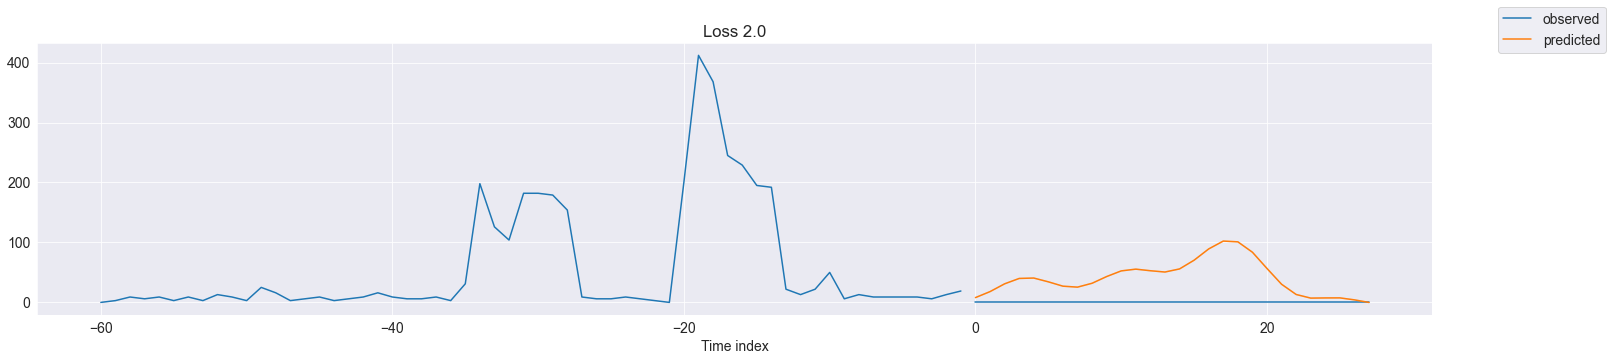

In [147]:
raw_predictions, x =  net.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    net.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

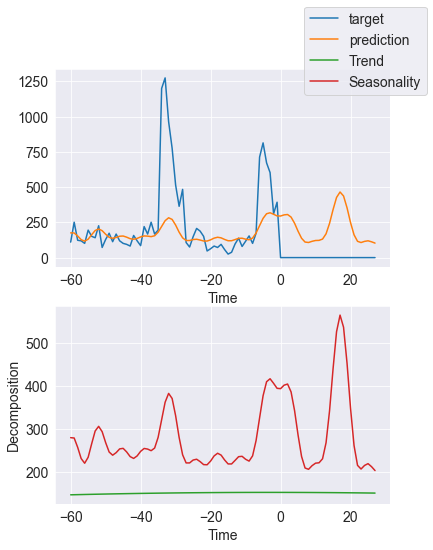

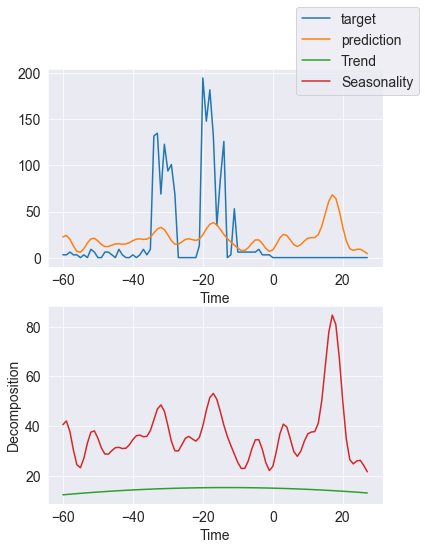

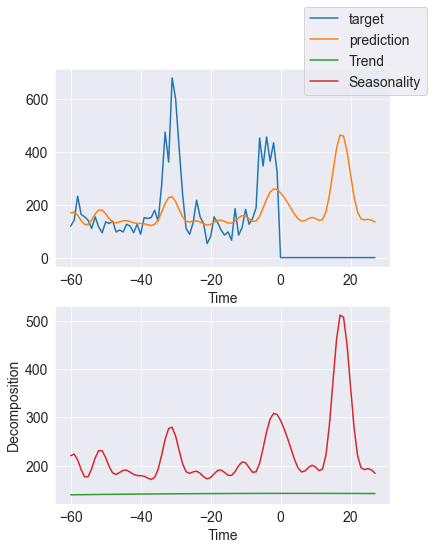

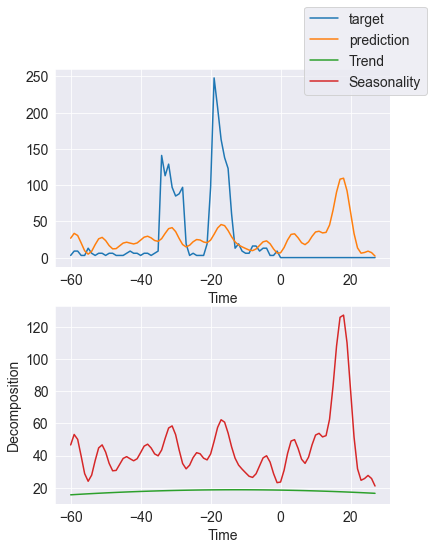

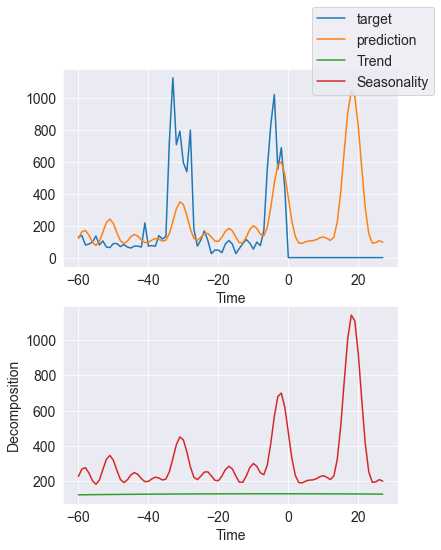

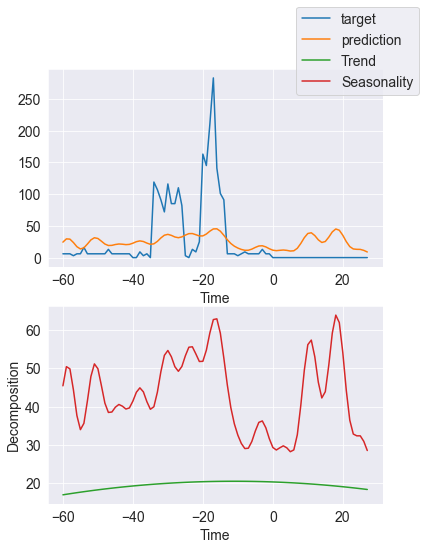

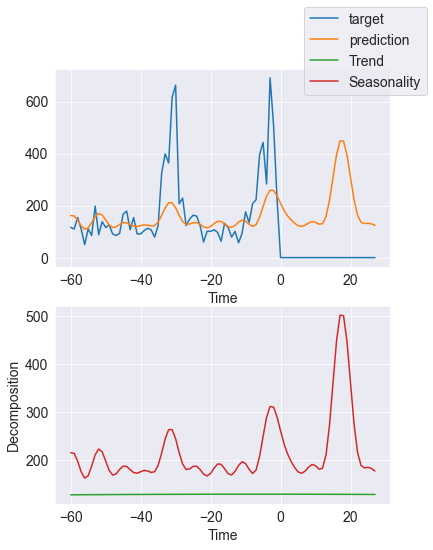

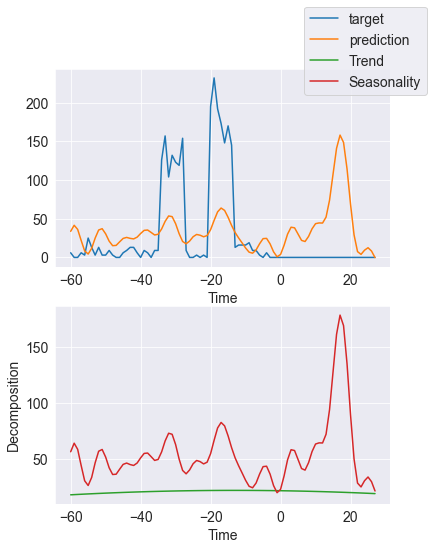

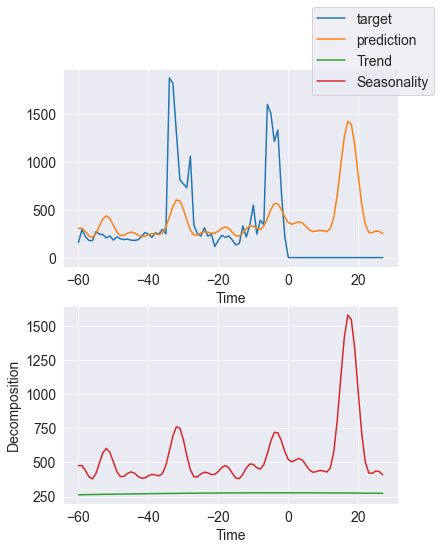

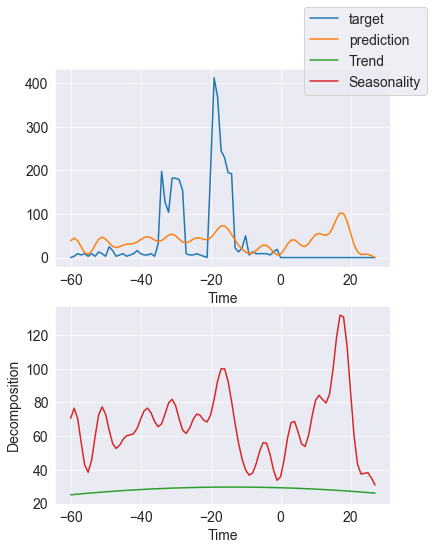

In [148]:
for idx in range(10):  # plot 10 examples
    net.plot_interpretation(x, raw_predictions, idx=idx);

In [124]:
training_cutoff = df_train["time_idx"].max()
validation = TimeSeriesDataSet.from_dataset(training, pd.concat([df_train, df_test]).reset_index(), min_prediction_idx=training_cutoff + 1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [125]:
pred, ind = net.predict(val_dataloader, return_index=True)

In [126]:
res_test = pd.read_csv('test_kaggle.csv')
res_test['Date'] = pd.to_datetime(res_test['Date'])
res_test['pred'] = None
res_test.head()

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price,pred
0,1,1,2016-05-23,1.0,NaN,128.98,119.6,None
1,1,1,2016-05-24,NaN,NaN,128.98,NaN,None
2,1,1,2016-05-25,NaN,NaN,131.70,NaN,None
3,1,1,2016-05-26,NaN,NaN,131.70,NaN,None
4,1,1,2016-05-27,NaN,NaN,131.70,NaN,None


In [127]:
for i in range(pred.shape[0]):
    store, sku = int(ind.iloc[i]['Store_id']), int(ind.iloc[i]['SKU_id'])
    res_test.loc[(res_test['Store_id'] == store) & (res_test['SKU_id'] == sku), 'pred'] = pred[i].numpy()

In [128]:
ans_68 = pd.read_csv('68.csv')
ans_68

,id,Demand
0,0,661.365900
1,1,150.649200
2,2,133.698240
3,3,142.240630
4,4,136.909260
...,...,...
5965,5965,3.979614
5966,5966,6.695038
5967,5967,6.142532
5968,5968,2.497055


In [129]:
res_test.loc[res_test['pred'].isna(), 'pred'] = ans_68[res_test['pred'].isna()]['Demand'].values

In [130]:
res_test = res_test[['pred']].rename(columns={'pred' : 'Demand'})
res_test.to_csv('ans.csv', index_label='id')

In [131]:
res_test

,Demand
0,295.030609
1,303.108643
2,305.769928
3,287.456085
4,243.96106
...,...
5965,3.979614
5966,6.695038
5967,6.142532
5968,2.497055


In [132]:
res_test = pd.read_csv('test_kaggle.csv')
res_test['Date'] = pd.to_datetime(res_test['Date'])
res_test['pred'] = None
res_test.head()

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price,pred
0,1,1,2016-05-23,1.0,NaN,128.98,119.6,None
1,1,1,2016-05-24,NaN,NaN,128.98,NaN,None
2,1,1,2016-05-25,NaN,NaN,131.70,NaN,None
3,1,1,2016-05-26,NaN,NaN,131.70,NaN,None
4,1,1,2016-05-27,NaN,NaN,131.70,NaN,None


In [133]:
for i in range(pred.shape[0]):
    store, sku = int(ind.iloc[i]['Store_id']), int(ind.iloc[i]['SKU_id'])
    res_test.loc[(res_test['Store_id'] == store) & (res_test['SKU_id'] == sku), 'pred'] = pred[i].numpy()

In [134]:
ans_68 = pd.read_csv('68.csv')
ans_68

,id,Demand
0,0,661.365900
1,1,150.649200
2,2,133.698240
3,3,142.240630
4,4,136.909260
...,...,...
5965,5965,3.979614
5966,5966,6.695038
5967,5967,6.142532
5968,5968,2.497055


In [135]:
res_test.loc[res_test['pred'].isna(), 'pred'] = ans_68[res_test['pred'].isna()]['Demand'].values

In [136]:
res_test = res_test[['pred']].rename(columns={'pred' : 'Demand'})
res_test.to_csv('ans.csv', index_label='id')

In [137]:
res_test

,Demand
0,295.030609
1,303.108643
2,305.769928
3,287.456085
4,243.96106
...,...
5965,3.979614
5966,6.695038
5967,6.142532
5968,2.497055
